## $\color{red}{\text{Lecture Overview}}$
1. **Multiple Linear Regression**
2. **Developing the Analytic Task**
3. **Data Transformation**
4. **Data Visualization**
5. **Data Modeling**

## $\color{red}{\text{Multiple Linear Regression}}$

1. Used to describe a linear relationship between a dependent variable and independent variables
2. **Simple linear regression** will be of the form: **$y=b_0 + b_1X_1$**
3. **Multiple linear regression** will be of the form: $y=b_0 + b_1X_1 + ... + b_kX_k $
    - $y$ is the **dependent variable** and $X_1, X_2, ..., X_k$ are the **independent variables**
4. The goal is to determine the coefficients $b_0, b_1, ..., b_k$ in order to reduce prediction error

## $\color{red}{\text{Import Required Packages}}$

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## $\color{red}{\text{Import Data}}$

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DS4510/Data
housingData= pd.read_excel('housingData.xlsx', sheet_name='housingData')

/content/drive/MyDrive/DS4510/Data


## $\color{red}{\text{Analytic Task}}$
1. Using the housing data, build a **mulptiple linear regression model** to predict **price**
2. Perform data transformation methods wherever needed
3. Perform data visualization tasks to develop a preliminary understanding of **price**
4. Develop a model to predict **price**
5. Assess the robustness of the model
6. Interpret the model for insights

## $\color{red}{\text{Data Transformation}}$


### $\color{blue}{\text{Missing Value Analysis}}$

- Check missing values in the data

In [ ]:
def show_missing_vals(df:pd.DataFrame)->pd.DataFrame:
    return df.isna().sum().divide(len(df)).sort_values(ascending=False)

show_missing_vals(housingData)

,0
id,0.0
sqft_above,0.0
sqft_lot15,0.0
sqft_living15,0.0
long,0.0
lat,0.0
zipcode,0.0
yr_renovated,0.0
yr_built,0.0
sqft_basement,0.0


### $\color{blue}{\text{Multicollinearity}}$

1. Using a correlation plot, find variables with strong association with the dependent variable, **price**
2. **Multicollinearity** occurs when variables have similar information
    - Variables with a correlation greater than 0.70 are considered to have similar information
    - One of the variables should not be included in the analysis
3. Which variables are closely related to each other?

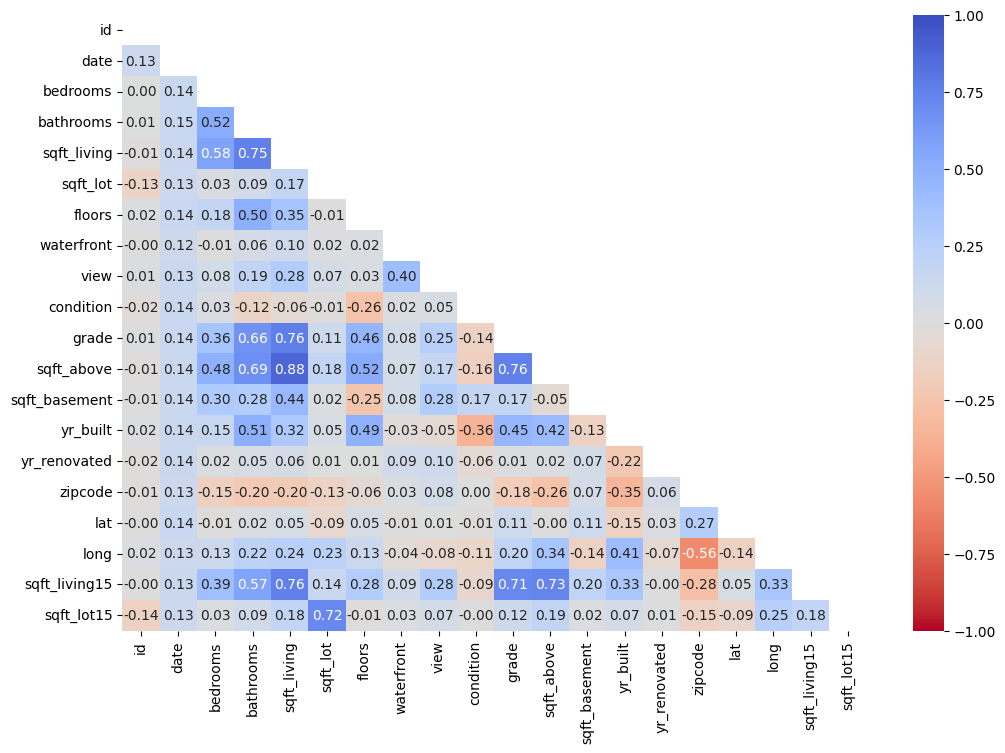

In [ ]:
#!pip install dython
from dython.nominal import associations
import seaborn as sns

def corrplot(data, dep_var):
  #Use associations function to compute correlations between alll variables except the dependent variable
  corr_matrix = associations(dataset=data.drop("price", axis=1), compute_only = True)['corr']
  #Mask upper triangle of the correlation heatmap
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))
  #Plot the heatmap
  plt.figure(figsize=(12,8))
  sns.heatmap(corr_matrix, annot=True, mask=mask_upper, cmap = "coolwarm_r", fmt='.2f', vmin = -1, vmax =1)
  plt.show()



corrplot(housingData, "price")

In [ ]:
#Drop the following variables from the data as they are not needed for the analysis
drop_vars=['id', 'date', 'zipcode']
new_housing = housingData.drop(drop_vars, axis=1)

#Dependent variable is Y in Y=mx+b while X is your independent variable

### $\color{blue}{\text{Removing Colinear Variables}}$
- If correlation between variables are greater than 0.7, one of the variables should be removed

In [ ]:
#Create a function to remove highly correlated values from the data

def removeHighCorr (data,dep_var,thresh):
  corr_matrix=associations(dataset=data.drop(dep_var,axis=1), compute_only=True)['corr'].abs()

  upper_tri=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

  to_drop=[column for column in upper_tri.columns if any(upper_tri[column]>thresh)]

  new_data=data.drop(to_drop,axis=1)

  return new_data

housing_noHigh= removeHighCorr(new_housing,'price',0.7)

### $\color{blue}{\text{Removing Near Zero-Variance Variables}}$
- Some variables have little or no variation. They do not add much value to the model

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(housing_noHigh)

vars = housing_noHigh.columns[vThreshold.get_support()]

housing_varDf = housing_noHigh[vars] #New data from scrubing
housing_varDf.head()

,bedrooms,bathrooms,sqft_lot,floors,view,condition,sqft_basement,yr_built,yr_renovated,price
0,3,1.00,5650,1.0,0,3,0,1955,0,221900.0
1,3,2.25,7242,2.0,0,3,400,1951,1991,538000.0
2,2,1.00,10000,1.0,0,3,0,1933,0,180000.0
3,4,3.00,5000,1.0,0,5,910,1965,0,604000.0
4,3,2.00,8080,1.0,0,3,0,1987,0,510000.0


In [ ]:
#Standardizing Data
housing_std = StandardScaler().fit_transform(housing_varDf)
housing_std = pd.DataFrame(housing_std, columns = housing_varDf.columns)
#housing_std.head()

In [ ]:
housing_std.head()

,bedrooms,bathrooms,sqft_lot,floors,view,condition,sqft_basement,yr_built,yr_renovated,price
0,-0.398737,-1.447464,-0.228321,-0.915427,-0.305759,-0.629187,-0.658681,-0.544898,-0.210128,-0.866419
1,-0.398737,0.175607,-0.189885,0.936506,-0.305759,-0.629187,0.245141,-0.681079,4.746678,-0.005940
2,-1.473959,-1.447464,-0.123298,-0.915427,-0.305759,-0.629187,-0.658681,-1.293892,-0.210128,-0.980478
3,0.676485,1.149449,-0.244014,-0.915427,-0.305759,2.444294,1.397515,-0.204446,-0.210128,0.173723
4,-0.398737,-0.149007,-0.169653,-0.915427,-0.305759,-0.629187,-0.658681,0.544548,-0.210128,-0.082161


## $\color{red}{\text{Model Building}}$

### $\color{blue}{\text{Data Partitioning}}$

1. Identify dependent and independent variables
2. Partition the data such that 80% is used for training and 20% is used for testing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

dep_variable = housing_std['price']
ind_variable = housing_std.loc[:, housing_std.columns != 'price']

train_x, test_x, train_y, test_y = train_test_split(ind_variable, dep_variable, test_size=0.2, random_state=42)

### $\color{blue}{\text{Model Fitting and Result}}$

In [ ]:
import statsmodels.api as sm
#Add intercept term into the data before modeling
train_X = sm.add_constant(train_x)
#Model with training data
model = sm.OLS(train_y, train_X).fit()
#print model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     1430.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:46:59   Log-Likelihood:                -19453.
No. Observations:               17290   AIC:                         3.893e+04
Df Residuals:                   17280   BIC:                         3.900e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0044      0.006     -0.777

1. Explain the model coefficient. <br>
In this case, I will explain the coefficient of the 'bedrooms' variable
  - For one unit increase in **(ind. variable)**, the **(dep variable)** increases/ decreases by **(the coefficient of the ind variable)**, while holding all the independet variables constant
  - For one unit increase in bedrooms, the price increases by 0.0121, while holding all the independet variables constant.

------
1. Explain the R-squared
- The independent variables, explains (r-quared value) of the (dependent variable)
- The independent variables, explains 43% of price


### $\color{blue}{\text{Model Prediction}}$

- Predict the **price** of the testing data as a function of the independent variables

In [ ]:
test_X = sm.add_constant(test_x)

pred_train = model.predict(train_X)
pred_test = model.predict(test_X)

## $\color{red}{\text{Model Diagnostics}}$

### $\color{blue}{\text{QQ Plot}}$

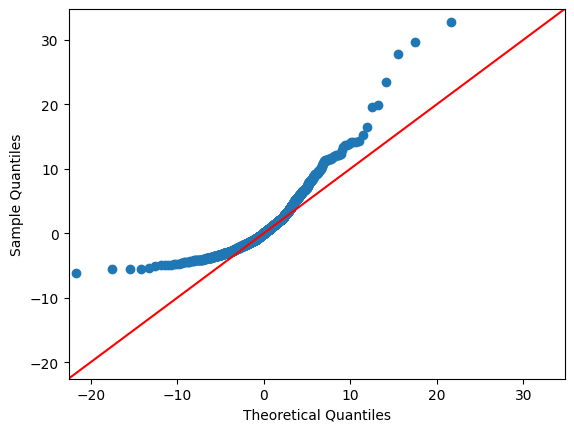

In [ ]:
import scipy.stats as stats

residual = model.resid
fig=sm.qqplot(residual, stats.t, fit=True, line='45')

plt.show()

### $\color{blue}{\text{Error Calculations}}$

- Mean Error (ME), Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE), Mean Percentage Error (MPE)
- Mean Absolute Percentage Error (MAPE)

In [ ]:
!pip install dmba
from dmba import regressionSummary

#Smallest error model is best

print ("Trainning data")
regressionSummary(train_y, pred_train)


print ("Testing data")
regressionSummary(test_y, pred_test)

Trainning data

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.7454
            Mean Absolute Error (MAE) : 0.4887
          Mean Percentage Error (MPE) : 139.3499
Mean Absolute Percentage Error (MAPE) : 482.1665
Testing data

Regression statistics

                      Mean Error (ME) : 0.0220
       Root Mean Squared Error (RMSE) : 0.8091
            Mean Absolute Error (MAE) : 0.5083
          Mean Percentage Error (MPE) : 1.2416
Mean Absolute Percentage Error (MAPE) : 482.7711
